In [1]:
import numpy as np
import csv
%matplotlib inline
import pandas as pd
from frgpascal.hardware.sampletray import SampleTray, AVAILABLE_VERSIONS as sampletray_versions
from frgpascal.hardware.liquidlabware import TipRack, LiquidLabware, AVAILABLE_VERSIONS as liquid_labware_versions
from frgpascal.hardware.hotplate import AVAILABLE_VERSIONS as hotplate_versions
from frgpascal.experimentaldesign.helpers import build_sample_list, plot_tray, handle_liquids, samples_to_dataframe
from frgpascal.experimentaldesign.tasks import *
from frgpascal.experimentaldesign.scheduler import Scheduler
from frgpascal.experimentaldesign.protocolwriter import generate_ot2_protocol
import mixsol as mx

------

# Define hardware for this experiment

In [2]:
print('Available Sample Tray Versions:')
for v in sampletray_versions:
    print(f'\t{v}')

print('\nAvailable Liquid Labwares:')
for v in liquid_labware_versions:
    print(f'\t{v}')

Available Sample Tray Versions:
	storage_v3
	storage_v2
	storage_v1

Available Liquid Labwares:
	frg_12_wellplate_15000ul
	sartorius_safetyspace_tiprack_200ul
	greiner_96_wellplate_360ul
	frg_spincoater_v1
	frg_24_wellplate_4000ul


## Sample Storage Trays
These are the trays used to load samples in/out of the glovebox

In [3]:
sample_trays = [
    SampleTray(
        name='Tray1',
        version='storage_v1',
        gantry=None,
        gripper=None,
        p0=[0,0,0]
    ),
    SampleTray(
        name='Tray2',
        version='storage_v1',
        gantry=None,
        gripper=None,
        p0=[0,0,0]
    )
]

## Liquid Labware 

Include _all possible_ liquid storage + pipette tipracks. Later on we will narrow this down to what is required once we know what solutions and volumes we need.

Versions are defined by the same json files used to define custom labware for the Opentrons2 liquid handler. 
New labware can be defined by following https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions

The location of the labware/tiprack on the opentrons deck must be specified as well.


| Deck | Slot | Layout |
| ----------- | ----------- | ----------- |
| 10      | 11       | _Trash_ |
| 7   | 8        | 9 |
|4 | 5 | 6|
|1 | _Spin_ | _Coater_|

In [4]:
solution_storage = [
    LiquidLabware(
        name='96_Plate1',
        version='greiner_96_wellplate_360ul',
        deck_slot=5
    ),
    LiquidLabware(
        name='4mL_Tray1',
        version='frg_24_wellplate_4000ul',
        deck_slot=1
    ),
    LiquidLabware(
        name='15mL_Tray1',
        version='frg_12_wellplate_15000ul',
        deck_slot=8  
    ),
]

#sort by volume,name
solution_storage.sort(key=lambda labware: labware.name)
solution_storage.sort(key=lambda labware: labware.volume)
print('Priority Fill Order:')
for ss in solution_storage: print(ss)

Priority Fill Order:
<LiquidLabware> 96_Plate1, 0.36 mL volume, 96 wells
<LiquidLabware> 4mL_Tray1, 4.0 mL volume, 24 wells
<LiquidLabware> 15mL_Tray1, 15.0 mL volume, 12 wells


In [5]:
tipracks = [
    TipRack(
        version='sartorius_safetyspace_tiprack_200ul', 
        deck_slot=7,
        starting_tip="A3"),
    TipRack(
        version='sartorius_safetyspace_tiprack_200ul', 
        deck_slot=10,
        starting_tip="B5"),
    ]

-----

# Define Experimental Mesh

Each of the following cells defines one dimension of the experiment. After defining the individual dimensions, a full sample list will be constructed using a user-selected Design of Expeiment (DOE)

## List of unique substrates that will be loaded to start the experiment.
These are just strings to describe the substrate 

In [6]:
input_substrates = [
    '2mm_FTO'
]

## Solutions to spincast. 

Solutions are defined using `Solution` class instances.

Chemical formula is defined with underscores between each component. If no coefficient is provided, assumes =1. Example:

``` 
SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```

Antisolvents are also defined using `Solution` class instances. Solutes are left empty, and molarity is unused so can be left as 1/whatever number you like.

Example:
``` 
Solution(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    )
```

Solutions that will be interchanged (for example, different absorber solutions for compositional search) should be stored in a list. This list will be used later to permute sample process variables


In [7]:
absorber_solutions = [
    Solution(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    Solution(
        solutes='FA0.5_MA0.5_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    Solution(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    # Solution(
    #     solutes='FA0.25_MA0.75_Pb_I3',
    #     solvent='DMF9_DMSO1',
    #     molarity=1
    # ),
    # Solution(
    #     solutes='FA0.75_MA0.25_Pb_I3',
    #     solvent='DMF9_DMSO1',
    #     molarity=1
    # ),
    # Solution(
    #     solutes='MA0.5_FA0.5_Pb_I3',
    #     solvent='DMF9_DMSO1',
    #     molarity=1
    # ),
]


In [8]:
antisolvents = [
    Solution(
        solvent='Chlorobenzene',
    ),
    Solution(
        solvent='MethylAcetate',
    )
]

In [9]:
solution_spiro = Solution(
    solutes='spiro',
    solvent='IPA',
    molarity=1
)

## Spincoating Recipes


Spincoating recipes are defined using the `Spincoat` object. This takes two arguments: `steps`,a nested list of [speed, acceleration, duration] spin steps, and `drops`, a list of `Drop` objects that capture the details of each solution drop during spincoating. 

```
Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops=[
            Drop(
                solution=target_solutions[0],
                volume=20, # uL
                time=5, # seconds from start of spincoating
                height=2, # mm above substrate to dispense from, optional
                rate=50, # dispense rate (uL/sec), optional
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                time=30
            )
        ]
    )
```

often we will be using many solutions with the same spincoating recipe. In these cases, the `solution` argument of a `Drop` object can just be a string. This string can be substituted by a list of solutions at the final step. Example:

```
spincoat_recipes = [
    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution', # we will fill any Drop solutions labeled as 'psk_solution' later
                volume=20,
                time=5
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                time=40
            )
        ]
    ),
```

#### Defining spincoating parameters

In [10]:
absorber_spincoat_recipes = [
    Spincoat(
        steps=[
            [5000,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution',  #this will be filled later using the list of psk solutions
                volume=20,
                time=5
            ),
            Drop(
                solution='antisolvent', #this will similarly be filled later
                volume=50,
                time=40,
            )
        ]
    ),
    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution',
                volume=20,
                time=-1,
            ),
            Drop(
                solution='antisolvent',
                volume=50,
                time=40,
                reuse_tip=True
            )
        ]
    ),
]

In [11]:
spincoat_spiro = Spincoat(
    steps=[
        [5000,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
        [4000,4000,30]
    ],
    drops = [
        Drop(
            solution=solution_spiro,
            volume=20,
            time=5
        ),
    ],
)
        

## Annealing Conditions
Annealing conditions are defined as a list of `Anneal` class instances. Only two parameters - temperature (C) and duration (s)

Example:
``` 
    Anneal(
        temperature=100, #degrees C
        duration=60*60, #seconds
    ),
```

In [12]:
anneal_recipes = [
    Anneal(
        temperature=100, #degrees C
        duration=10*60, #seconds
    ),
    Anneal(
        temperature=100, #degrees C
        duration=15*60, #seconds
    ),
]

anneal_spiro = Anneal(
    temperature=100, #degrees C
    duration=10*60, #seconds
)

-----

# Design of Experiment

We will input all the values defined above into `build_sample_list` to generate a sample list. Currently only a full-factorial design is implemented. 
The arguments for `build_sample_list` are as follows:
- `input_substrates`: list of substrates (strings) describing the unique starting substrates
- `steps`: worklist of process steps (`Spincoat`, `Anneal`, `Rest`, or `Characterize`) **in desired order of completion**. Each of the list elements can be a single step (if the step does not change across samples), or a list of steps of the same kind (for example, a list of spincoat variations)
- `solution_mesh`: a dictionary used to fill in solution placeholders in `Drop` objects. Keys should match the placeholder strings, and values should be lists of `Solution` objects to put into the `Drop` object.
- `n_repeats`: number of duplicates to run for each unique worklist

arguments are lists defined above, and n_repeats is the number of times to repeat each unique combination of conditions

In [13]:
samples = build_sample_list(
    available_trays = sample_trays,
    input_substrates = input_substrates,
    steps = [
        absorber_spincoat_recipes, #list of absorber `Spincoat` variations
        anneal_recipes, #list of `Anneal` variations
        Rest(300), #move the sample to the sample tray for at least 300 seconds
        Characterize(), #characterize the sample
        Rest(1),
        spincoat_spiro, #the one spincoat recipe for spiro
        anneal_spiro,
    ],
    solution_mesh=dict(
        psk_solution=absorber_solutions,
        antisolvent=antisolvents
    ),
    n_repeats=1
)
print(len(samples))

24


In [14]:
df = samples_to_dataframe(samples)
df.head()

,name,storage_tray,storage_slot,worklist,spincoat0_steps,spincoat0_duration,spincoat0_drop0_solutes,spincoat0_drop0_solvent,spincoat0_drop0_molarity,spincoat0_drop0_time,...,spincoat1_steps,spincoat1_duration,spincoat1_drop0_solutes,spincoat1_drop0_solvent,spincoat1_drop0_molarity,spincoat1_drop0_time,spincoat1_drop0_height,spincoat1_drop0_rate,anneal1_temperature,anneal1_duration
0,sample0,Tray1,A1,"[{'sample': 'sample0', 'start': nan, 'task': '...","[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",92,MA_Pb_I3,DMF9_DMSO1,1,5,...,"[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",68,spiro,IPA,1,5,2,100,100,600
1,sample1,Tray1,A2,"[{'sample': 'sample1', 'start': nan, 'task': '...","[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",92,MA_Pb_I3,DMF9_DMSO1,1,5,...,"[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",68,spiro,IPA,1,5,2,100,100,600
2,sample2,Tray1,A3,"[{'sample': 'sample2', 'start': nan, 'task': '...","[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",92,FA0.5_MA0.5_Pb_I3,DMF9_DMSO1,1,5,...,"[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",68,spiro,IPA,1,5,2,100,100,600
3,sample3,Tray1,A4,"[{'sample': 'sample3', 'start': nan, 'task': '...","[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",92,FA0.5_MA0.5_Pb_I3,DMF9_DMSO1,1,5,...,"[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",68,spiro,IPA,1,5,2,100,100,600
4,sample4,Tray1,A5,"[{'sample': 'sample4', 'start': nan, 'task': '...","[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",92,FA_Pb_I3,DMF9_DMSO1,1,5,...,"[{'rpm': 5000.0, 'acceleration': 1000.0, 'dura...",68,spiro,IPA,1,5,2,100,100,600


-----

# Preparing the Solutions

## Define Stock Solutions

These are the solutions that you will be mixing to (hopefully) cover your target solutions. If they don't work, the code will tell you, and you can come back to this point and try again.

In [15]:
stock_solutions = [
    Solution(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    Solution(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    Solution(
        solvent='DMF',
    ),
    Solution(
        solvent='DMSO',
    ),
    Solution(
        solvent='Chlorobenzene',
    ),
    Solution(
        solvent='MethylAcetate',
    ),
    Solution(
        solutes='spiro',
        solvent='IPA',
        molarity=1
    ),
]

Can we cover target solutions with these stocks? and if so, how much of each stock to mix for each target?

This will throw an error if the stock solutions are not able to cover our experiment

In [16]:
required_solutions = {}
for s in samples:
    for task in s.worklist:
        if isinstance(task, Spincoat):
            for d in task.drops:
                sol = d.solution
                if sol in required_solutions:
                    required_solutions[sol] += d.volume
                else:
                    required_solutions[sol] = d.volume + 50

In [17]:
mixer = mx.Mixer(
    stock_solutions=stock_solutions,
    targets=required_solutions,
)
mixer.solve(
    min_volume=20,
    max_inputs=4,
    tolerance=1e-4
)

In [18]:
mixer.print()

===== Stock Prep =====
315.00 of 1M FA_Pb_I3 in DMF9_DMSO1
650.00 of Chlorobenzene
530.00 of 1M spiro in IPA
315.00 of 1M MA_Pb_I3 in DMF9_DMSO1
650.00 of MethylAcetate
====== Mixing =====
Distribute 1M FA_Pb_I3 in DMF9_DMSO1:
	105.00 to 1M FA0.5_MA0.5_Pb_I3 in DMF9_DMSO1
Distribute 1M MA_Pb_I3 in DMF9_DMSO1:
	105.00 to 1M FA0.5_MA0.5_Pb_I3 in DMF9_DMSO1


-----

In [19]:
solution_details = {}
for s in mixer.solutions:
    solution_details[s] = {
        'largest_volume_required': round(mixer.initial_volumes_required.get(s,0), 3),
        'is_stock': mixer.solutions.index(s) in mixer.stock_idx
    }

In [20]:

def where_to_store(volume, options):
    for ll in options:
        if volume <= ll.volume and len(ll._openwells) > 0:
            return ll
    raise ValueError(f"No options have enough space to hold {volume/1e3:.2f} mL!")



In [21]:
for ll in solution_storage:
    ll.unload_all()
    
for solution, v in solution_details.items():
    if solution.well['labware'] is None:
        continue
    volume = v['largest_volume_required']
    ll = [ll for ll in solution_storage if ll.name == solution.well['labware']][0]
    well = ll.load(solution, well=solution.well['well'])
    solution_details[solution]["labware"] = ll.name
    solution_details[solution]["well"] = well
    if v['is_stock']:
        solution_details[solution]['initial_volume_required'] = v['largest_volume_required'] 
    else:
        solution_details[solution]['initial_volume_required'] = 0
    
for solution, v in solution_details.items():
    if 'labware' in v:
        continue
    volume = v['largest_volume_required']
    ll = where_to_store(volume, solution_storage)  # which liquid labware
    well = ll.load(solution)
    solution_details[solution]["labware"] = ll.name
    solution_details[solution]["well"] = well
    if v['is_stock']:
        solution_details[solution]['initial_volume_required'] = v['largest_volume_required'] 
    else:
        solution_details[solution]['initial_volume_required'] = 0


In [22]:
for s in samples:
    for task in s.worklist:
        if not isinstance(task, Spincoat):
            continue
        for drop in task.drops:
            d = solution_details[drop.solution]
            drop.solution.well = {
                "labware": d["labware"],
                "well": d["well"],
            }

In [23]:
mixing_netlist = []  # [{source: {[destinations], [volumes]}}, {source:{[destinations], [volumes]}}] 
for generation in mixer.transfers_per_generation:
    this_generation = {}
    for source, transfers in generation.items():
        labware = solution_details[source]['labware']
        well = solution_details[source]['well']
        source_str = f"{labware}-{well}"
        transfers_from_this_source = {}
        for destination, volume in transfers.items():
            if volume == 0:
                continue
            labware = solution_details[destination]['labware']
            well = solution_details[destination]['well']
            destination_str = f"{labware}-{well}"
            transfers_from_this_source[destination_str] = volume.round(2)
        this_generation[source_str] = transfers_from_this_source
    mixing_netlist.append(this_generation)

# Build the Experiment Schedule + Save Worklist

solution status: FEASIBLE


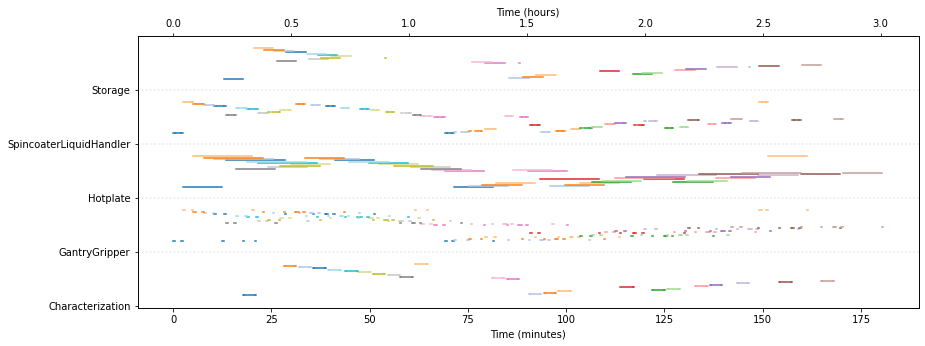

In [24]:
scheduler = Scheduler(
    samples=samples,
    spanning_tasks = ["characterize", "spincoat"], #these tasks spanning each pair must be done in sequence per sample
    enforce_sample_order=False
)
ordered_tasks = scheduler.solve(2) #argument defines how long (s) to work on finding a solution
plt.savefig('Experiment Schedule', dpi=300, bbox_inches='tight')

# Write final files to disk

## Plot + save images that map the solution + substrate loading positions

Solution map

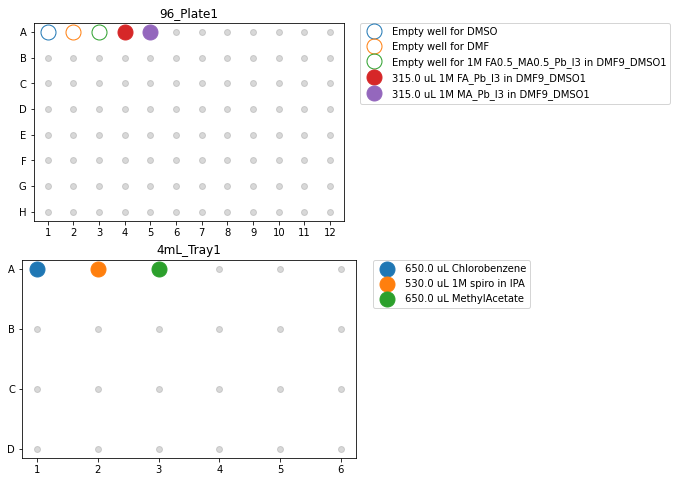

In [25]:
ll_with_solutions = [
    ll for ll in solution_storage
    if len(ll.contents) > 0
]

fig, ax = plt.subplots(len(ll_with_solutions), 1, figsize=(6,4*len(ll_with_solutions)))
try:
    ax = ax.flat
except:
    ax = [ax]
for ll, ax_ in zip(ll_with_solutions, ax):
    ll.plot(solution_details=solution_details, ax=ax_)
plt.savefig("solution_map.jpeg", dpi=150, bbox_inches='tight')

Substrate map

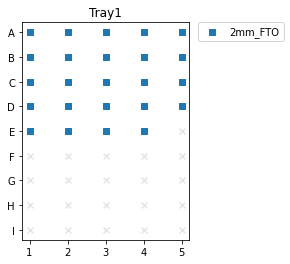

In [26]:
st_with_samples = [
    st for st in sample_trays
    if len(st.contents) > 0
]

fig, ax = plt.subplots(len(st_with_samples), 1, figsize=(3,4*len(st_with_samples)))
try:
    ax = ax.flat
except:
    ax = [ax]
for ll, ax_ in zip(st_with_samples, ax):
    ll.plot(ax=ax_)
plt.savefig("tray_map.jpeg", dpi=150, bbox_inches='tight')

## Generate protocol for Opentrons liquid handler

In [28]:
generate_ot2_protocol(
    'Example Output.py',
    mixing_netlist= mixing_netlist,
    labware=solution_storage,
    tipracks=tipracks)
    

## Maestro netlist to disk, will be input to maestro to execute experiment

In [29]:
ordered_task_output = [task.to_dict() for task in ordered_tasks]

samples_output = {sample.name:sample.to_dict() for sample in samples}
out = {
    'samples': samples_output,
    'tasks': ordered_task_output,
}
with open('maestronetlist.json', 'w') as f:
    json.dump(out, f, indent=4, sort_keys=True)
print('Maestro Netlist dumped to "maestronetlist.json"')

Maestro Netlist dumped to "maestronetlist.json"


## Solution Instructions to csv, tells operator where/how much to put solutions

In [30]:
with open('stock_solutions.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    header = [
        'Labware',
        'Well',
        'Volume (uL)',
        'Solutes',
        'Molarity (M)',
        'Solvent',        
    ]
    writer.writerow(header)
    for solution, details in solution_details.items():
        volume = details['initial_volume_required']
        if volume == 0:
            volume = 'Empty Vial'
        line = [
            details['labware'],
            details['well'],
            volume,
            solution.solutes,
            solution.molarity,
            solution.solvent,
        ]
        writer.writerow(line)